In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Reading Data and Data Preprocessing

In [28]:
raw_data = pd.read_csv("data_raw.csv")
raw_data

,Account,ATMID,caldate,Dispense,DT,MaxCapacity,CountTotalTxn
0,ABC,SPCN02020,01-01-2021,564500,0,2640000,157
1,ABC,TPCN10269,01-01-2021,509000,9,3520000,92
2,ABC,APCN00816,01-01-2021,64800,0,2640000,36
3,PQR,S1CN1142,01-01-2021,834500,0,3520000,101
4,PQR,S1CN2022,01-01-2021,825700,0,2860000,364
...,...,...,...,...,...,...,...
14588,XYZ,T1BH000274012,22-02-2023,381700,0,2860000,126
14589,XYZ,T1NH000575414,22-02-2023,452500,565,3520000,134
14590,PQR,S1CN2011,22-02-2023,0,0,3520000,0
14591,XYZ,T1BH007252090,22-02-2023,137600,0,3520000,73


In [29]:
df = raw_data

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14593 entries, 0 to 14592
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Account        14593 non-null  object
 1   ATMID          14593 non-null  object
 2   caldate        14593 non-null  object
 3   Dispense       14593 non-null  int64 
 4   DT             14593 non-null  int64 
 5   MaxCapacity    14593 non-null  int64 
 6   CountTotalTxn  14593 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 798.2+ KB


In [31]:
df.columns

Index(['Account', 'ATMID', 'caldate', 'Dispense', 'DT', 'MaxCapacity',
       'CountTotalTxn'],
      dtype='object')

In [32]:
# Convert 'date_column' from object type to datetime type
df['date'] = pd.to_datetime(df['caldate'],format='%d-%m-%Y')

In [33]:
# One-Hot Encoding for the bank Column
df1 = df[['Account','ATMID','date','MaxCapacity','CountTotalTxn','Dispense']]
df1

,Account,ATMID,date,MaxCapacity,CountTotalTxn,Dispense
0,ABC,SPCN02020,2021-01-01,2640000,157,564500
1,ABC,TPCN10269,2021-01-01,3520000,92,509000
2,ABC,APCN00816,2021-01-01,2640000,36,64800
3,PQR,S1CN1142,2021-01-01,3520000,101,834500
4,PQR,S1CN2022,2021-01-01,2860000,364,825700
...,...,...,...,...,...,...
14588,XYZ,T1BH000274012,2023-02-22,2860000,126,381700
14589,XYZ,T1NH000575414,2023-02-22,3520000,134,452500
14590,PQR,S1CN2011,2023-02-22,3520000,0,0
14591,XYZ,T1BH007252090,2023-02-22,3520000,73,137600


## Analyzing Data

In [34]:
# Count rows where the value of dispense is less than 10
count_less_than_10 = df1[df1['Dispense'] < 10].shape[0]
count_less_than_10

1003

In [35]:
# Drop rows where the value of dispense is less than 10
df1 = df1[df1['Dispense'] >= 10]

In [36]:
# Find counts of unique values in the column "MaxCapacity"
value_counts = df['MaxCapacity'].value_counts()
value_counts

MaxCapacity
3520000    9281
2860000    2180
2640000    1566
3740000     783
2420000     783
Name: count, dtype: int64

In [37]:
def visualize_numerical_variables(dataframe, numerical_vars):
    for var in numerical_vars:
        # Create a new figure with subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Plot Histogram
        sns.histplot(dataframe[var], kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram of {var}')
        axes[0].ticklabel_format(style='plain', axis='both')

        # Plot Box Plot
        sns.boxplot(x=dataframe[var], ax=axes[1])
        axes[1].set_title(f'Box Plot of {var}')

        # Adjust layout
        plt.tight_layout()

        # Show the plots
        plt.show()

In [38]:
numerical_vars = ['CountTotalTxn','Dispense']

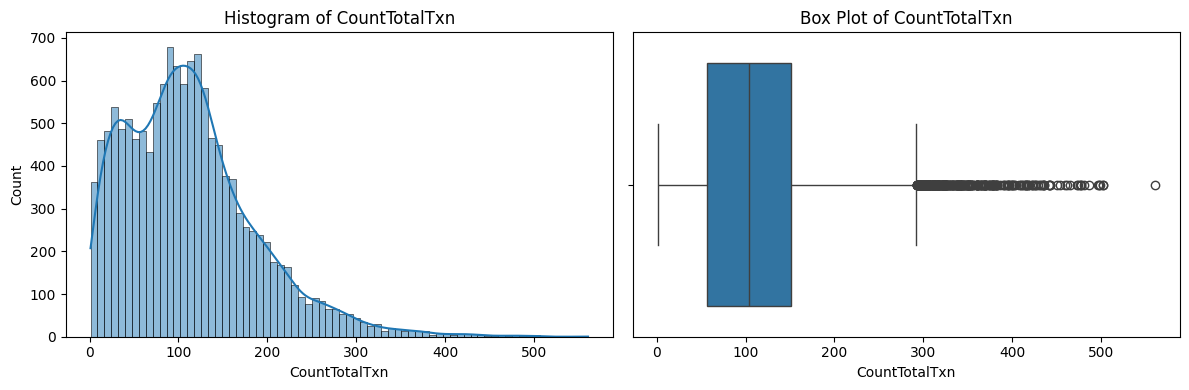

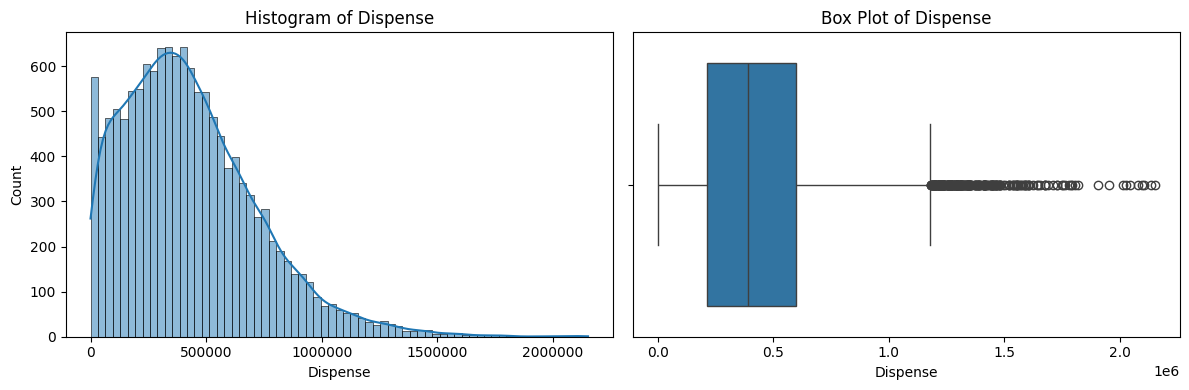

In [39]:
visualize_numerical_variables(df1, numerical_vars)

### Oberservation-

Number of Transactions made in a day Median is around 100 Transaction

Also in Dispense Amount this is close to 4,00,000 (4 Lacs)

In [40]:
cat_var = ['Account', 'ATMID', 'MaxCapacity']

In [41]:
def generate_class_table(dataframe, target_column):
    class_table = pd.DataFrame(columns=['Column Name', 'Classes', 'Count', 'Percentage', 'Y Mean'])
    for column in cat_var:
        classes = dataframe[column].value_counts()
        total_count = classes.sum()
        percentages = (classes / total_count) * 100

        #y_counts = dataframe[dataframe[target_column] == 'Y'][column].value_counts()
        y_means = dataframe.groupby(column)[target_column].mean()
        
        for class_value, count, percentage, y_means in zip(
            classes.index, classes.values, percentages.values, y_means.values
        ):
            data = {
                'Column Name': column,
                'Classes': class_value,
                'Count': count,
                'Percentage': round(percentage, 2),
                'Y Mean': round(y_means)
            }
            class_table = pd.concat([class_table,pd.DataFrame(data, index=[0])])
            class_table.reset_index(drop=True, inplace=True)

    return class_table

In [42]:
summary_1 = generate_class_table(df1,"Dispense")
summary_1

C:\Users\talkt\AppData\Local\Temp\ipykernel_27420\2784373382.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  class_table = pd.concat([class_table,pd.DataFrame(data, index=[0])])


,Column Name,Classes,Count,Percentage,Y Mean
0,Account,ABC,5021,36.95,384140
1,Account,PQR,4838,35.60,447228
2,Account,XYZ,3731,27.45,478584
3,ATMID,T1NY000166081,766,5.64,353334
4,ATMID,APCN00816,765,5.63,447341
5,ATMID,S1CN2022,760,5.59,508033
6,ATMID,TPCN10269,759,5.58,101989
7,ATMID,S1CN2820,748,5.50,108395
8,ATMID,SPCN02020,738,5.43,286904
9,ATMID,APAN23217,735,5.41,156037


In [43]:
def percentile_values(data):

    # Define percentiles
    percentiles = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]  # You can add any other percentiles as needed

    # Calculate values at each percentile
    percentile_values = np.percentile(data, percentiles)

    # Print the values at each percentile
    for p, value in zip(percentiles, percentile_values):
        print(f'{p}th percentile: {value}')

In [44]:
percentile_values(df1['CountTotalTxn'])

1th percentile: 4.0
10th percentile: 25.0
20th percentile: 46.0
30th percentile: 68.0
40th percentile: 87.0
50th percentile: 104.0
60th percentile: 121.0
70th percentile: 139.0
80th percentile: 166.0
90th percentile: 210.0
99th percentile: 344.0


In [45]:
percentile_values(df1['Dispense'])

1th percentile: 5000.0
10th percentile: 86500.0
20th percentile: 173000.0
30th percentile: 251500.0
40th percentile: 322000.0
50th percentile: 390700.0
60th percentile: 463500.0
70th percentile: 547000.0
80th percentile: 654540.0000000001
90th percentile: 818000.0
99th percentile: 1319704.0000000037


## Feature Engineering

In [46]:
df1.loc[:,'day_of_week_number'] = df1['date'].dt.dayofweek
df1.loc[:,'quarter'] = df1['date'].dt.quarter
df1.loc[:,'month'] = df1['date'].dt.month
df1.loc[:,'year'] = df1['date'].dt.year
df1.loc[:,'day_of_year'] = df1['date'].dt.dayofyear
df1.loc[:,'week'] = df1['date'].dt.isocalendar().week

C:\Users\talkt\AppData\Local\Temp\ipykernel_27420\2992334599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'day_of_week_number'] = df1['date'].dt.dayofweek
C:\Users\talkt\AppData\Local\Temp\ipykernel_27420\2992334599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'quarter'] = df1['date'].dt.quarter
C:\Users\talkt\AppData\Local\Temp\ipykernel_27420\2992334599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [47]:
df1

,Account,ATMID,date,MaxCapacity,CountTotalTxn,Dispense,day_of_week_number,quarter,month,year,day_of_year,week
0,ABC,SPCN02020,2021-01-01,2640000,157,564500,4,1,1,2021,1,53
1,ABC,TPCN10269,2021-01-01,3520000,92,509000,4,1,1,2021,1,53
2,ABC,APCN00816,2021-01-01,2640000,36,64800,4,1,1,2021,1,53
3,PQR,S1CN1142,2021-01-01,3520000,101,834500,4,1,1,2021,1,53
4,PQR,S1CN2022,2021-01-01,2860000,364,825700,4,1,1,2021,1,53
...,...,...,...,...,...,...,...,...,...,...,...,...
14587,XYZ,T1BH000603091,2023-02-22,3520000,87,208000,2,1,2,2023,53,8
14588,XYZ,T1BH000274012,2023-02-22,2860000,126,381700,2,1,2,2023,53,8
14589,XYZ,T1NH000575414,2023-02-22,3520000,134,452500,2,1,2,2023,53,8
14591,XYZ,T1BH007252090,2023-02-22,3520000,73,137600,2,1,2,2023,53,8


<Axes: xlabel='day_of_week_number', ylabel='Dispense'>

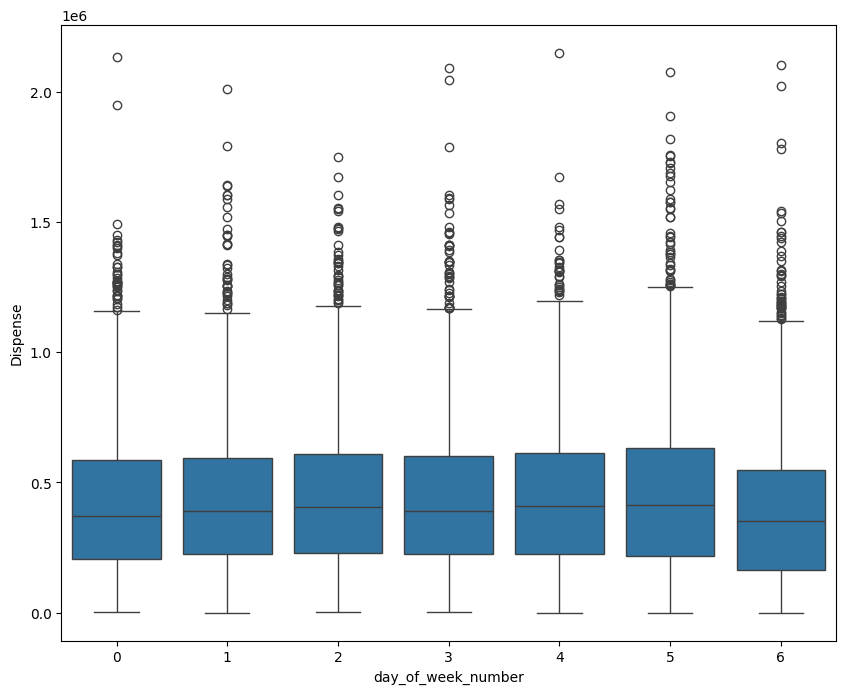

In [48]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df1, x = 'day_of_week_number', y = 'Dispense')

# Monday = 0, Sunday = 6

### Oberservation 1 -

Sundays have a lower Disbursal of cash

<Axes: xlabel='month', ylabel='Dispense'>

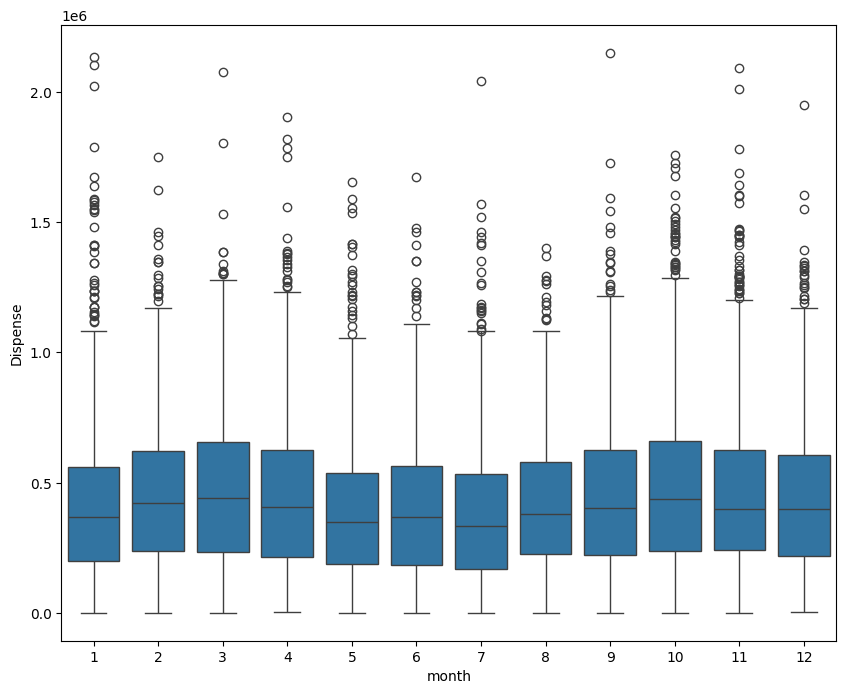

In [49]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df1, x = 'month', y = 'Dispense')

### Oberservation 2-

March and October months form peaks in Dispense Amounts

<Axes: xlabel='quarter', ylabel='Dispense'>

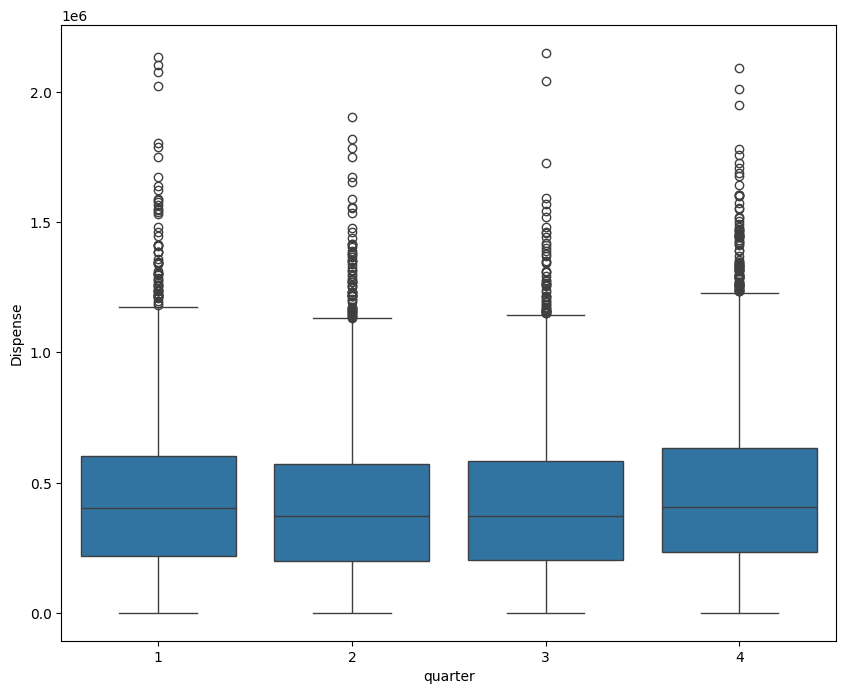

In [50]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df1, x = 'quarter', y = 'Dispense')

In [51]:
# One-Hot Encoding for the bank Column
one_hot_ecoded_banks = pd.get_dummies(df1['Account'], prefix='bank')
one_hot_ecoded_atm = pd.get_dummies(df1['ATMID'], prefix='ATM')

In [52]:
# Concatenating the encoded DataFrame with the main DataFrame
df2 = pd.concat([df1, one_hot_ecoded_banks, one_hot_ecoded_atm], axis=1)

In [53]:
df2

,Account,ATMID,date,MaxCapacity,CountTotalTxn,Dispense,day_of_week_number,quarter,month,year,...,ATM_SPCND067,ATM_SPCNG376,ATM_T1BH000003039,ATM_T1BH000011116,ATM_T1BH000274012,ATM_T1BH000603091,ATM_T1BH007252090,ATM_T1NH000575414,ATM_T1NY000166081,ATM_TPCN10269
0,ABC,SPCN02020,2021-01-01,2640000,157,564500,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,False
1,ABC,TPCN10269,2021-01-01,3520000,92,509000,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,True
2,ABC,APCN00816,2021-01-01,2640000,36,64800,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,False
3,PQR,S1CN1142,2021-01-01,3520000,101,834500,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,False
4,PQR,S1CN2022,2021-01-01,2860000,364,825700,4,1,1,2021,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,XYZ,T1BH000603091,2023-02-22,3520000,87,208000,2,1,2,2023,...,False,False,False,False,False,True,False,False,False,False
14588,XYZ,T1BH000274012,2023-02-22,2860000,126,381700,2,1,2,2023,...,False,False,False,False,True,False,False,False,False,False
14589,XYZ,T1NH000575414,2023-02-22,3520000,134,452500,2,1,2,2023,...,False,False,False,False,False,False,False,True,False,False
14591,XYZ,T1BH007252090,2023-02-22,3520000,73,137600,2,1,2,2023,...,False,False,False,False,False,False,True,False,False,False


## Split Data into Training and Testing Sets

In [54]:
train = df2.loc[df2.date <= '2023-01-01']
test = df2.loc[df2.date > '2023-01-01']

In [55]:
df2.columns

Index(['Account', 'ATMID', 'date', 'MaxCapacity', 'CountTotalTxn', 'Dispense',
       'day_of_week_number', 'quarter', 'month', 'year', 'day_of_year', 'week',
       'bank_ABC', 'bank_PQR', 'bank_XYZ', 'ATM_APAN11109', 'ATM_APAN22403',
       'ATM_APAN23217', 'ATM_APAN35706', 'ATM_APCN00816', 'ATM_S1CN1142',
       'ATM_S1CN2011', 'ATM_S1CN2022', 'ATM_S1CN2820', 'ATM_S1CN3514',
       'ATM_SPCN02020', 'ATM_SPCND067', 'ATM_SPCNG376', 'ATM_T1BH000003039',
       'ATM_T1BH000011116', 'ATM_T1BH000274012', 'ATM_T1BH000603091',
       'ATM_T1BH007252090', 'ATM_T1NH000575414', 'ATM_T1NY000166081',
       'ATM_TPCN10269'],
      dtype='object')

In [56]:
features = ['day_of_week_number', 'quarter', 'month', 'year','day_of_year','week',
       'MaxCapacity',
       'bank_ABC', 'bank_PQR','bank_XYZ',
       'ATM_APAN11109','ATM_APAN22403', 'ATM_APAN23217', 'ATM_APAN35706', 'ATM_APCN00816',
       'ATM_S1CN1142', 'ATM_S1CN2011', 'ATM_S1CN2022', 'ATM_S1CN2820',
       'ATM_S1CN3514', 'ATM_SPCN02020', 'ATM_SPCND067', 'ATM_SPCNG376',
       'ATM_T1BH000003039', 'ATM_T1BH000011116', 'ATM_T1BH000274012',
       'ATM_T1BH000603091', 'ATM_T1BH007252090', 'ATM_T1NH000575414',
       'ATM_T1NY000166081', 'ATM_TPCN10269']
target = 'Dispense'

In [57]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [58]:
X_train

,day_of_week_number,quarter,month,year,day_of_year,week,MaxCapacity,bank_ABC,bank_PQR,bank_XYZ,...,ATM_SPCND067,ATM_SPCNG376,ATM_T1BH000003039,ATM_T1BH000011116,ATM_T1BH000274012,ATM_T1BH000603091,ATM_T1BH007252090,ATM_T1NH000575414,ATM_T1NY000166081,ATM_TPCN10269
0,4,1,1,2021,1,53,2640000,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,1,1,2021,1,53,3520000,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,4,1,1,2021,1,53,2640000,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1,1,2021,1,53,3520000,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,4,1,1,2021,1,53,2860000,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13496,6,1,1,2023,1,52,2860000,False,False,True,...,False,False,False,False,True,False,False,False,False,False
13497,6,1,1,2023,1,52,3520000,False,False,True,...,False,False,False,False,False,False,False,True,False,False
13498,6,1,1,2023,1,52,3520000,False,True,False,...,False,False,False,False,False,False,False,False,False,False
13499,6,1,1,2023,1,52,3520000,False,False,True,...,False,False,False,False,False,False,True,False,False,False


In [59]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12574, 31)
(12574,)
(1016, 31)
(1016,)


## Train the Model

In [60]:
reg = xgb.XGBRegressor(n_estimators = 1000, 
                       early_stopping_rounds = 50,
                       learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train),
                                      (X_test, y_test)],
                                      verbose = True)

[0]	validation_0-rmse:295426.25164	validation_1-rmse:254502.60796
[1]	validation_0-rmse:294452.34963	validation_1-rmse:253813.24449
[2]	validation_0-rmse:293494.53577	validation_1-rmse:253139.45313
[3]	validation_0-rmse:292552.57638	validation_1-rmse:252480.97699
[4]	validation_0-rmse:291626.25505	validation_1-rmse:251837.55991
[5]	validation_0-rmse:290713.50926	validation_1-rmse:251200.42956
[6]	validation_0-rmse:289843.59117	validation_1-rmse:250586.87605
[7]	validation_0-rmse:288986.69596	validation_1-rmse:249970.22196
[8]	validation_0-rmse:288144.23163	validation_1-rmse:249369.24821
[9]	validation_0-rmse:287316.99387	validation_1-rmse:248785.74014
[10]	validation_0-rmse:286502.53334	validation_1-rmse:248226.31785
[11]	validation_0-rmse:285700.41748	validation_1-rmse:247707.59070
[12]	validation_0-rmse:284911.89523	validation_1-rmse:247178.37018
[13]	validation_0-rmse:284136.80395	validation_1-rmse:246663.19447
[14]	validation_0-rmse:283374.87117	validation_1-rmse:246188.89747
[15]	

[19]	validation_0-rmse:279754.85628	validation_1-rmse:243899.46823
[20]	validation_0-rmse:279068.00991	validation_1-rmse:243467.81501
[21]	validation_0-rmse:278390.89377	validation_1-rmse:242904.01905
[22]	validation_0-rmse:277678.06527	validation_1-rmse:242466.50558
[23]	validation_0-rmse:277032.83216	validation_1-rmse:242040.36950
[24]	validation_0-rmse:276398.69208	validation_1-rmse:241481.82142
[25]	validation_0-rmse:275774.44688	validation_1-rmse:241078.69707
[26]	validation_0-rmse:275161.41176	validation_1-rmse:240541.88302
[27]	validation_0-rmse:274557.48576	validation_1-rmse:240168.01421
[28]	validation_0-rmse:273963.87895	validation_1-rmse:239660.49056
[29]	validation_0-rmse:273379.98492	validation_1-rmse:239299.44992
[30]	validation_0-rmse:272805.65342	validation_1-rmse:238827.97911
[31]	validation_0-rmse:272252.85621	validation_1-rmse:238442.10637
[32]	validation_0-rmse:271710.02815	validation_1-rmse:238075.71724
[33]	validation_0-rmse:271176.68187	validation_1-rmse:237712.8

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [61]:
pd.DataFrame(data=reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance']).sort_values(by=['importance'],ascending=False)

,importance
ATM_APCN00816,0.133803
ATM_APAN35706,0.133322
ATM_S1CN2011,0.085795
ATM_TPCN10269,0.066126
ATM_S1CN2022,0.065179
ATM_S1CN1142,0.064062
ATM_T1NY000166081,0.058696
ATM_SPCND067,0.047248
ATM_T1BH000274012,0.039660
ATM_T1BH000603091,0.037220


In [62]:
test['prediction']=reg.predict(X_test)

C:\Users\talkt\AppData\Local\Temp\ipykernel_27420\716901839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=reg.predict(X_test)


In [63]:
test.head()

,Account,ATMID,date,MaxCapacity,CountTotalTxn,Dispense,day_of_week_number,quarter,month,year,...,ATM_SPCNG376,ATM_T1BH000003039,ATM_T1BH000011116,ATM_T1BH000274012,ATM_T1BH000603091,ATM_T1BH007252090,ATM_T1NH000575414,ATM_T1NY000166081,ATM_TPCN10269,prediction
13501,ABC,SPCN02020,2023-01-02,2640000,62,259000,0,1,1,2023,...,False,False,False,False,False,False,False,False,False,434340.46875
13502,ABC,TPCN10269,2023-01-02,3520000,126,926500,0,1,1,2023,...,False,False,False,False,False,False,False,False,True,595365.62500
13503,ABC,APCN00816,2023-01-02,2640000,29,197000,0,1,1,2023,...,False,False,False,False,False,False,False,False,False,174383.81250
13505,PQR,S1CN2022,2023-01-02,2860000,245,728600,0,1,1,2023,...,False,False,False,False,False,False,False,False,False,903967.68750
13506,PQR,SPCND067,2023-01-02,3520000,168,972000,0,1,1,2023,...,False,False,False,False,False,False,False,False,False,568139.12500


In [71]:
test['prediction'] = test['prediction'].round()

C:\Users\talkt\AppData\Local\Temp\ipykernel_27420\1304112805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = test['prediction'].round()


In [72]:
test[['Account','date','Dispense','prediction']].tail(20)

,Account,date,Dispense,prediction
14565,XYZ,2023-02-21,456000,474567.0
14566,XYZ,2023-02-21,236500,403624.0
14567,XYZ,2023-02-21,303000,392236.0
14568,XYZ,2023-02-21,609000,438082.0
14569,PQR,2023-02-21,186600,191843.0
14571,XYZ,2023-02-21,390000,366465.0
14572,ABC,2023-02-22,176000,434340.0
14573,ABC,2023-02-22,528700,610212.0
14574,ABC,2023-02-22,95000,170938.0
14578,ABC,2023-02-22,280500,406357.0


In [87]:
test.shape

(1016, 37)

## Metric used for Model Accuracy

In [88]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['Dispense'], test['prediction'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 217559.5474935268


In [89]:
test['Dispense'].mean()

411121.55511811026